- Зайдите на портал https://physionet.org/, содержащий большую коллекцию физиологических и клинических данных и соответствующего программного обеспечения с открытым исходным кодом.   
- Перейдите в раздел "Data", далее "Neuroelectric and Myoelectric Databases" и выберите любой из представленных наборов данных ЭЭГ. Можно также взять запись ЭЭГ из любого другого открытого источника данных или выполненную
самостоятельно.  
- Проведите обработку и анализ данных, следуя плану, представленному в блокноте
https://drive.google.com/file/d/1jUq9I1xQkn6q3KAir9X4h1UHkVBLyEn5/view?usp=sharing.  
- На основе результатов  сделайте вывод о функциональном состоянии испытуемого в определенные моменты времени (расслабленное состояние, состояние напряженной умственной деятельности и т.д.).

Были взяты данные из https://physionet.org/content/ltrsvp/1.0.0/#files-panel

***MNE-Python*** - это пакет Python с открытым исходным кодом для изучения, визуализации и анализа нейрофизиологических сигналов человека, таких как МЭГ, ЭЭГ, электрокортикограммы (ECoG) и других. Он включает в себя модули для ввода/вывода данных, предварительной обработки, визуализации, частотно-временного анализа, анализа связности, машинного обучения и статистики.<br/>
С официальной документацией можно ознакомиться по ссылке: http://mne.tools/stable/

In [ ]:
pip install mne   ### УСТАНОВКА БИБЛИОТЕКИ ДЛЯ РАБОТЫ С ЭЭГ ДАННЫМИ

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.9 MB/s eta 0:00:00


In [ ]:
#### ИМПОРТИРУЕМ ДЛЯ ДАЛЬНЕЙШЕЙ РАБОТЫ
import mne
from mne import create_info, find_events, Epochs, EpochsArray, set_eeg_reference
import numpy as np
import matplotlib.pyplot as plt

from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval

In [ ]:
### импорт ЭЭГ файлов
rsvp = mne.io.read_raw_edf('Data/rsvp_10Hz_02a.edf',  preload=True) # загрузка файлов формата EDF
rsvp.drop_channels('Status Channel')

Extracting EDF parameters from /content/rsvp_10Hz_02a.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 514047  =      0.000 ...   251.000 secs...


<ipython-input-95-a67dc1e8f07f>:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  rsvp = mne.io.read_raw_edf('rsvp_10Hz_02a.edf',  preload=True) # загрузка файлов формата EDF
<ipython-input-95-a67dc1e8f07f>:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  rsvp = mne.io.read_raw_edf('rsvp_10Hz_02a.edf',  preload=True) # загрузка файлов формата EDF


<RawEDF | rsvp_10Hz_02a.edf, 8 x 514048 (251.0 s), ~31.4 MB, data loaded>

In [ ]:
# переименование каналов
def renamer(raw):
    a = raw.ch_names
    b = ['PO8','PO7', 'P8', 'P7', 'O1', 'O2', 'PO3', 'PO4']
    newch ={}
    for i in range(8):
        ch = {a[i]:b[i]}
        newch.update(ch)
    raw.rename_channels(newch)
    return raw

In [ ]:
rsvp = renamer(rsvp)

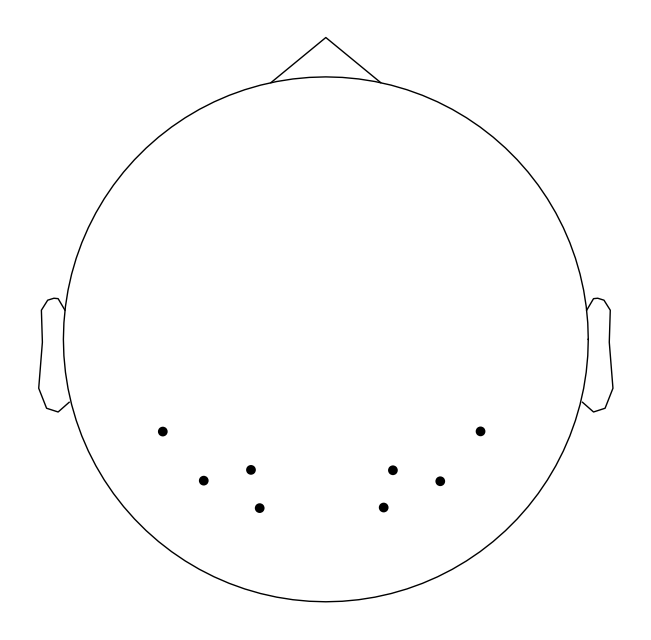

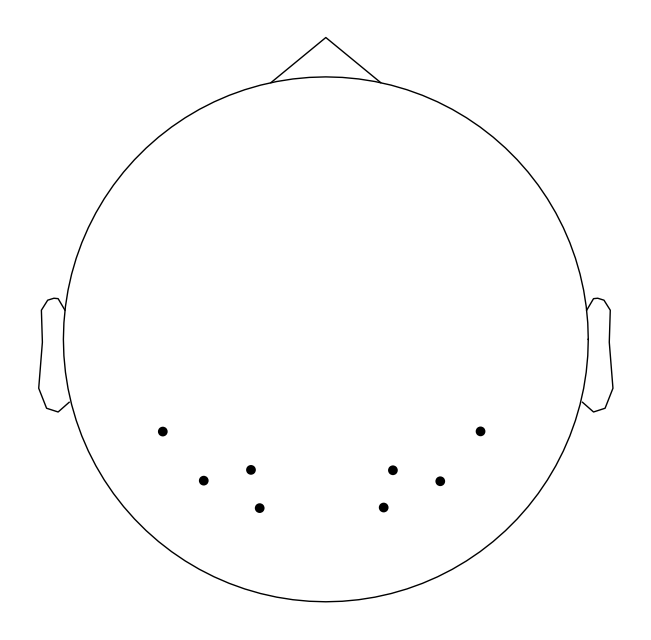

In [ ]:
### определяем схему монтажа, входные параметры: тип монтажа, размер головы (радиус в метрах, по умолчанию 95 мм)
montage = mne.channels.make_standard_montage('standard_1020') # расположение электродов в соответствии с международной системой 10-20
### установить монтаж
rsvp.set_montage(montage)  # вместо raw указывается название конкретной записи (rec1, rec2 или rec3)
### визуализация схемы монтажа
rsvp.plot_sensors()

Визуализация





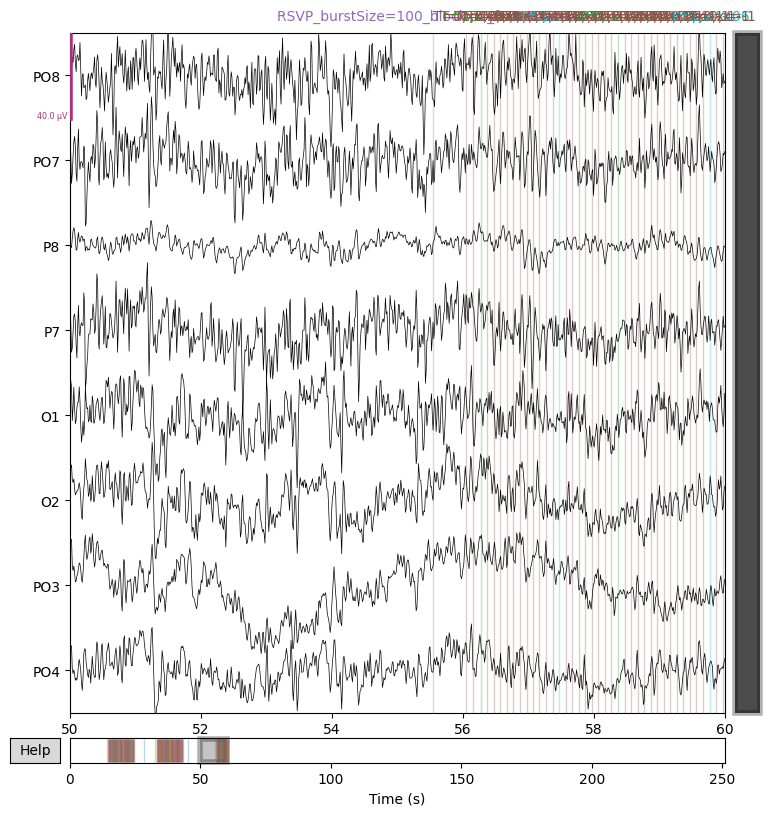

Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


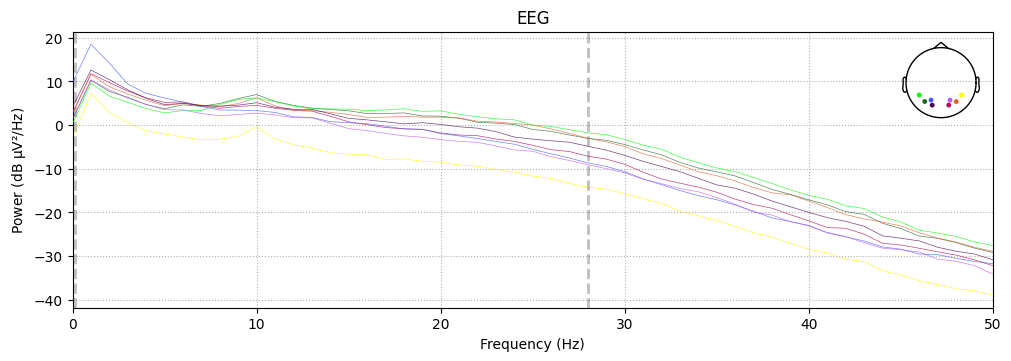

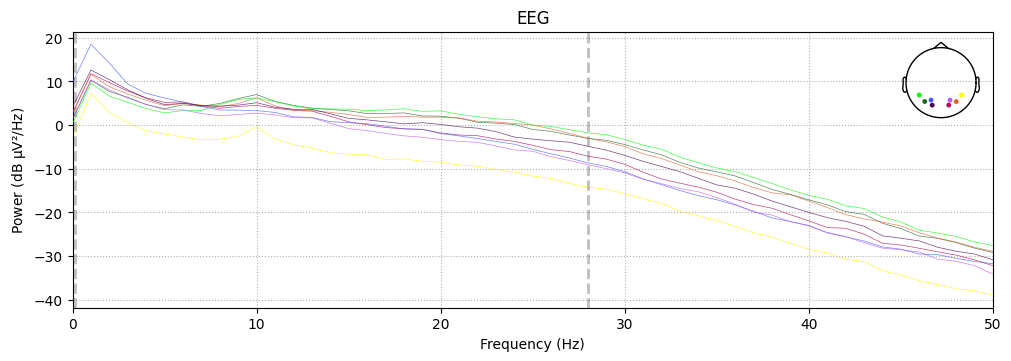

In [ ]:
rsvp.plot(start=50, duration=10, n_channels=8) # визуализация необработанных данных
rsvp.compute_psd(fmax=50).plot(amplitude=False) # спектральная плотность мощности (ограничиваемся частотами до 50 Гц)

Применение анализа независимых компонент для устранения артефактов

In [ ]:
# частотная фильтрация (выделение диапазона исследования)
filt_rsvp = rsvp.copy().filter(1, 45, fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6759 samples (3.300 s)



Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 15.6s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated


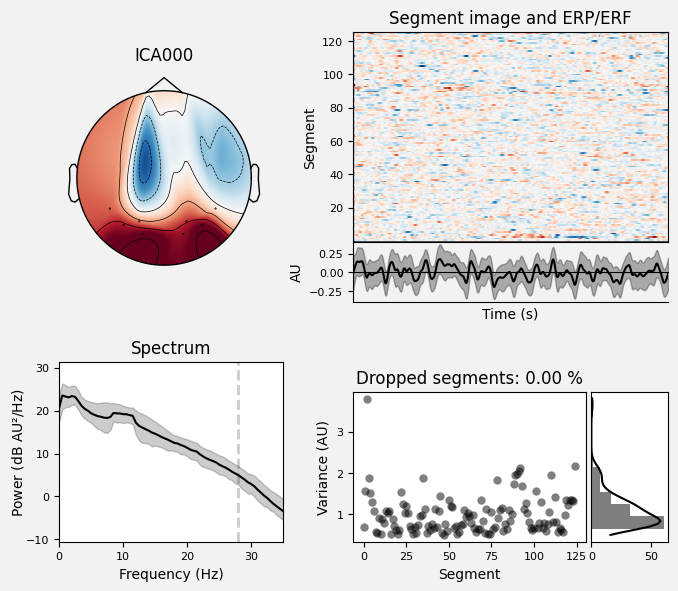

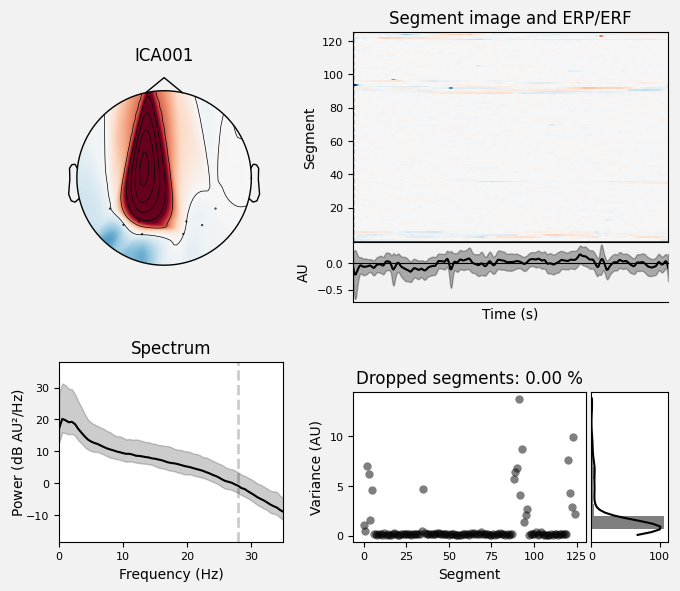

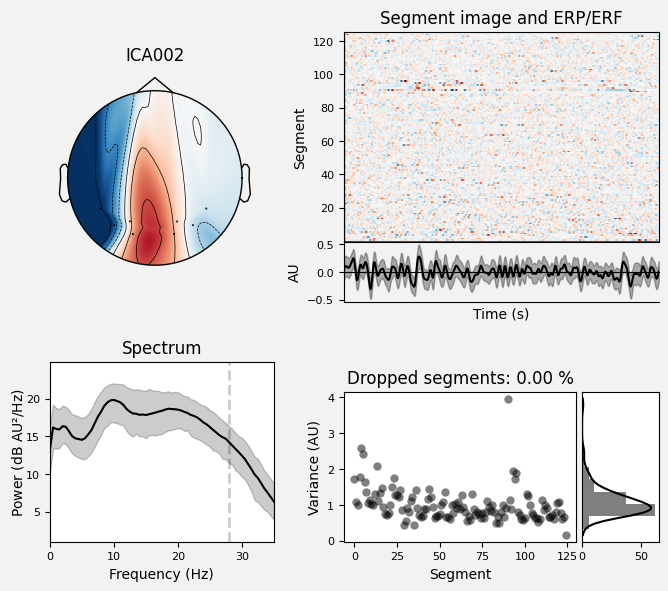

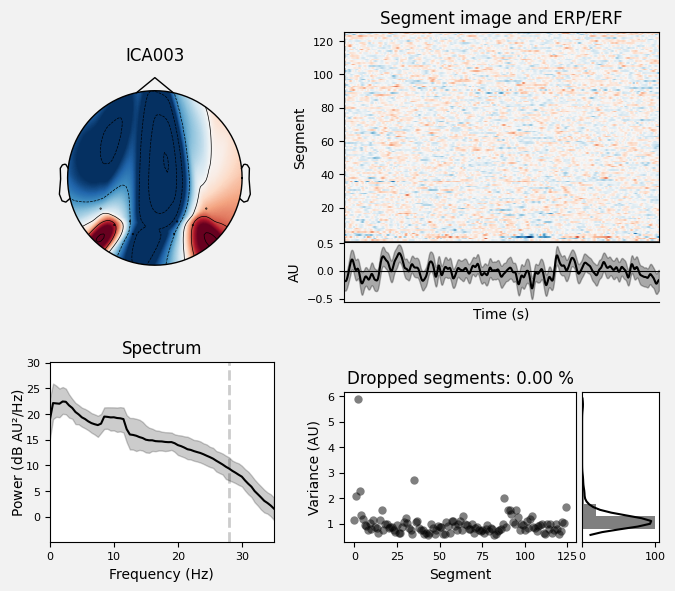

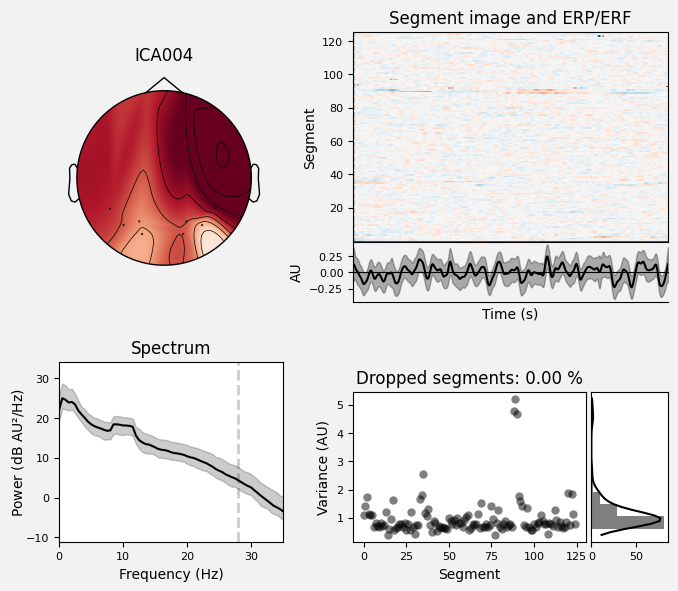

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [ ]:
ica = mne.preprocessing.ICA(n_components=8, random_state=48, max_iter=800)
ica.fit(filt_rsvp)

orig_rsvp = rsvp.copy()
ica.apply(filt_rsvp)

ica.plot_properties(filt_rsvp)

Сравним

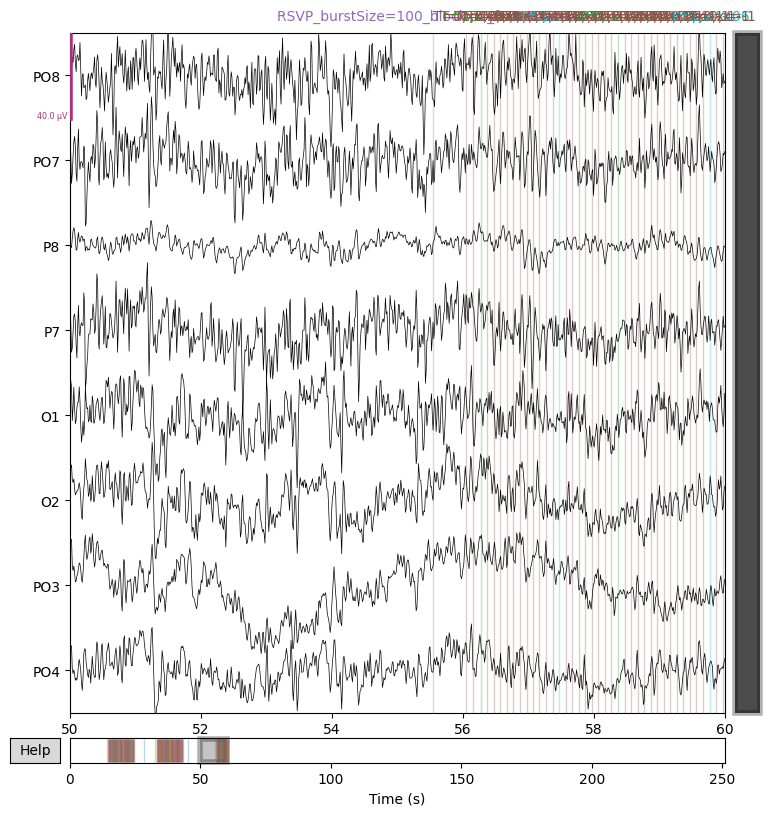

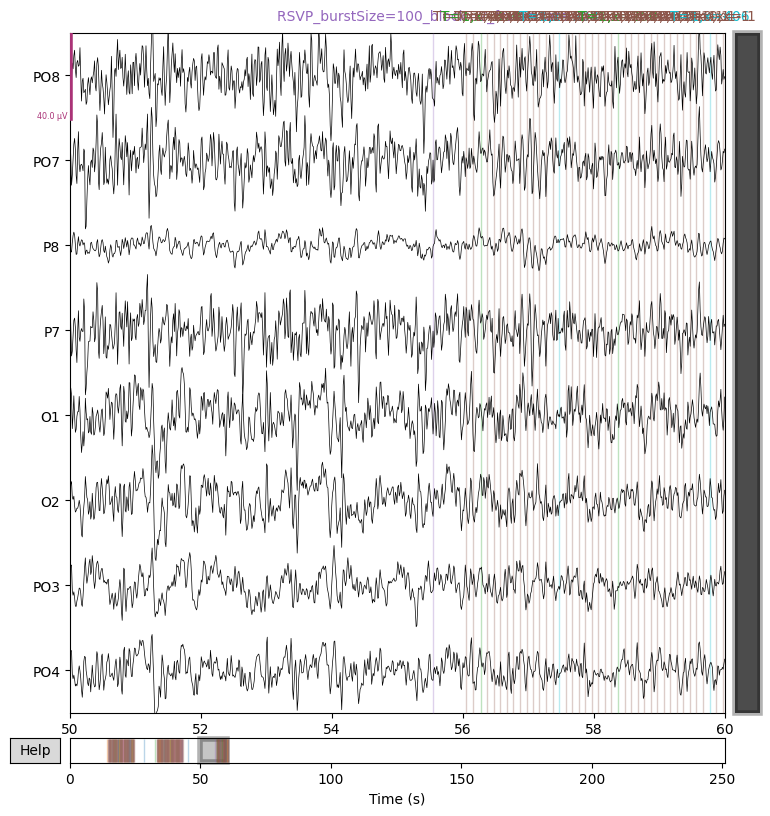

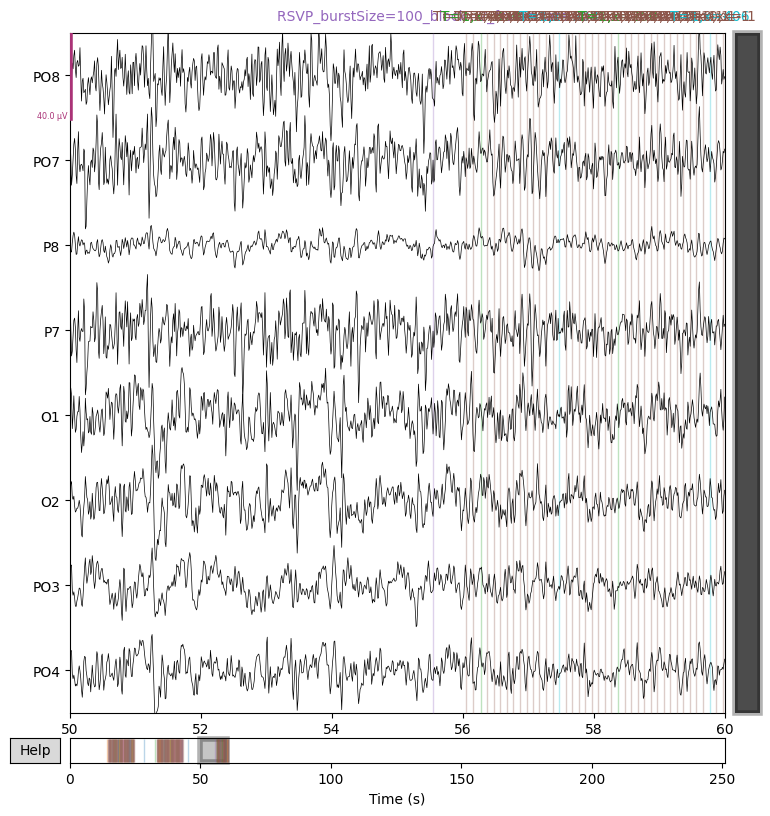

In [ ]:
orig_rsvp.plot(start=50, duration=10, n_channels=8)
filt_rsvp.plot(start=50, duration=10, n_channels=8)

<h4><b>Детектирование экспериментальных событий</b></h4>

Наборы данных могут содержать один или несколько триггер-каналов (trigger channel или stim channel), используемых для кодирования событий во время записи ЭЭГ. Как правило, сигнал в таком канале равен нулю и принимает положительные значения при наступлении некоторого события (начало стимула или реакция испытуемого). Такие каналы часто имеют префикс 'STI', чтобы отличать их от других типов каналов.<br/>
Функция `mne.find_events` осуществляет поиск событий в данных на основе значений триггер-канала. Если используется несколько триггерных каналов, то возвращаемые события будут объединением всех событий, извлеченных из отдельных каналов. Результирующий массив событий представляет собой обычный массив NumPy, в котором первый столбец содержит время наступления события (номер выборки), третий столбец - целочисленный идентификатор события, средний столбец обычно игнорируется. <br/>
Если указать `initial_event=True` (по умолчанию False), то событие создается, если триггер-канал имеет значение, отличное от 0 в качестве первого экземпляра. Это полезно, если присутствует событие в момент времени t = 0 с.<br/>
Вместо того чтобы отслеживать целочисленные идентификаторы событий, для удобства последующего анализа можно составить словарь событий, сопоставляющий целочисленные идентификаторы с экспериментальными событиями.

Помимо наличия триггерных каналов исходные данные могут содержать метки, которые можно достать из аннотаций, и на их основе детектировать события.

In [ ]:
events, ids = mne.events_from_annotations(filt_rsvp)
print(events[:5])  # show the first 5

Used Annotations descriptions: ['END', 'RSVP_burstSize=100_block=0_frame rate=6', 'RSVP_burstSize=100_block=1_frame rate=6', 'RSVP_burstSize=100_block=2_frame rate=6', 'T=0,x=-1', 'T=1,x=128', 'T=1,x=134', 'T=1,x=173', 'T=1,x=187', 'T=1,x=201', 'T=1,x=202', 'T=1,x=250', 'T=1,x=259', 'T=1,x=266', 'T=1,x=268', 'T=1,x=287', 'T=1,x=290', 'T=1,x=308', 'T=1,x=321', 'T=1,x=366', 'T=1,x=370', 'T=1,x=375', 'T=1,x=380', 'T=1,x=390', 'T=1,x=400', 'T=1,x=405', 'T=1,x=406', 'T=1,x=427', 'T=1,x=439', 'T=1,x=450']
[[28883     0     2]
 [29926     0     5]
 [30139     0     5]
 [30342     0    13]
 [30547     0     5]]


<h4><b>Разделение данных на эпохи</b></h4>

Массив и словарь событий используются для извлечения эпох из непрерывных данных. Также требуется задать временное окно, указав время начала (tmin) и окончания (tmax) каждой эпохи, которые рассчитываются относительно связанного с ней события.<br/>
При извлечении эпох можно одновременно ввести ограничения на качество данных, сразу отбрасывая эпохи, у которых амплитуда сигнала выходит за разумные пределы для данного типа канала. Это можно сделать с помощью словаря отклонений, указав в нем пороговые значения для всех типов каналов, присутствующих в данных, и передав его в качестве значения параметра <code>reject</code>. Однако такие значения должны подбираться отдельно для каждого конкретного набора данных, в зависимости от используемых  аппаратных средств и условий записи.

In [ ]:
epochs = mne.Epochs(filt_rsvp, events, event_id=ids, tmin=-0.2, tmax=0.5, preload=True)

Not setting metadata
251 matching events found
Setting baseline interval to [-0.2001953125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 251 events and 1435 original time points ...
0 bad epochs dropped


<h4><b>Оценка вызванных реакций</b></h5>

После выявления эпох, связанных с событиями, можно получить оценку вызванных реакций на стимулы, вычислив среднее значение по эпохам. <br/>
Более детальное представление об объекте `Evoked` можно получить с помощью методов визуализации, таких как `plot_joint` и `plot_topomap`.<br/>
`plot_topomap` строит топографические карты вызванных потенциалов в конкретных временных точках. Эти моменты времени могут быть заданы вручную или определены автоматически.<br/>
`plot_joint` изображает вызванные потенциалы в виде графика бабочки и добавляет топографические карты для временных точек.

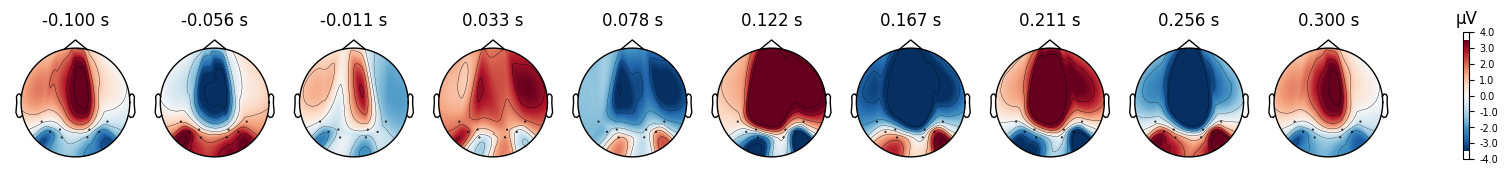

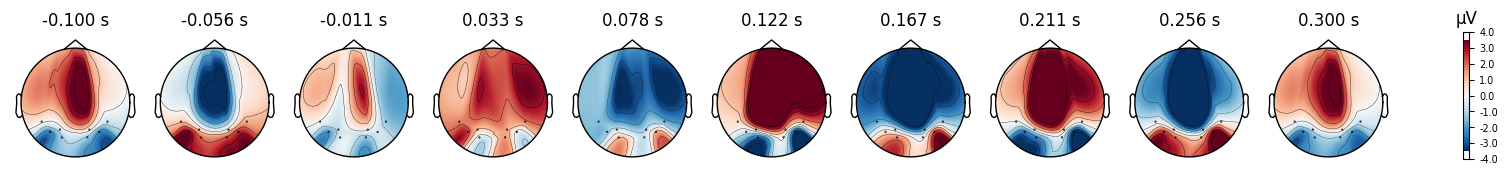

In [ ]:
evoked = epochs.average()
evoked.plot_topomap(times=np.linspace(-0.1, 0.3, 10))

No projector specified for this dataset. Please consider the method self.add_proj.


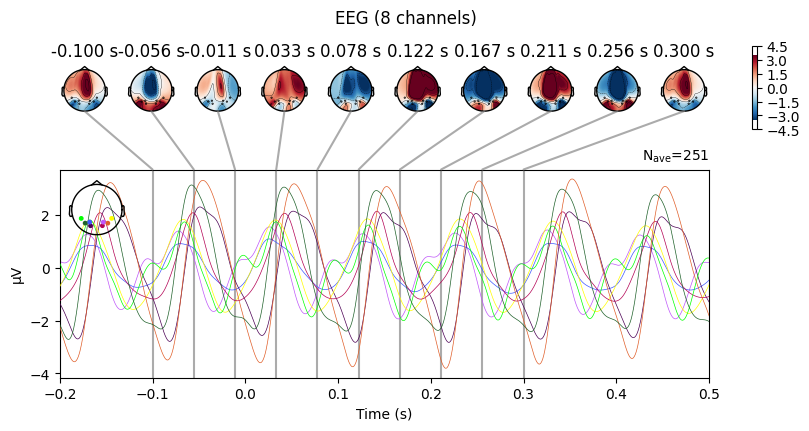

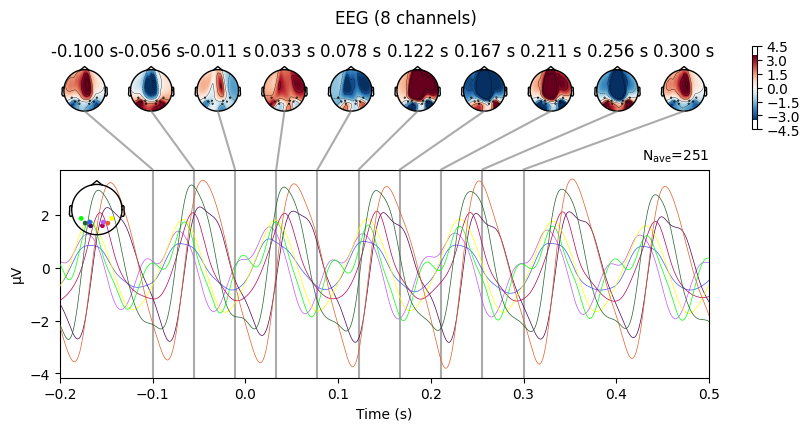

In [ ]:
evoked.plot_joint(times=np.linspace(-0.1, 0.3, 10))

**Оценка функционального состояния**<br/>
Оценка функционального состояния в определенные моменты времени (расслабленное состояние, состояние напряженной умственной деятельности и т.д.) может быть произведена по преобладанию тех или иных ритмов в общем сигнале ЭЭГ.<br/> Для этого, в частности, может быть использован метод на основе глобального поля мощности (GFP).<br/>
Пример применения данного метода: https://mne.tools/stable/auto_examples/time_frequency/time_frequency_global_field_power.html?highlight=alpha%20beta%20gamma



In [ ]:
# let's explore some frequency bands
baseline = None

iter_freqs = [("Theta", 4, 7), ("Alpha", 8, 12), ("Beta", 13, 29), ("Gamma", 30, 45)]

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = filt_rsvp.copy()
    #raw.pick(picks=["grad", "eog"])  # we just look at gradiometers
    raw.load_data()

    # bandpass filter
    raw.filter(
        fmin,
        fmax,
        n_jobs=None,  # use more jobs to speed up.
        l_trans_bandwidth=1,  # make sure filter params are the same
        h_trans_bandwidth=1,
    )  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(
        raw,
        events,
        event_id=1,
        tmin=-1,
        tmax=3.0,
        baseline=baseline,
        preload=True,
    )
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs
del raw

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 6759 samples (3.300 s)

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 8193 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

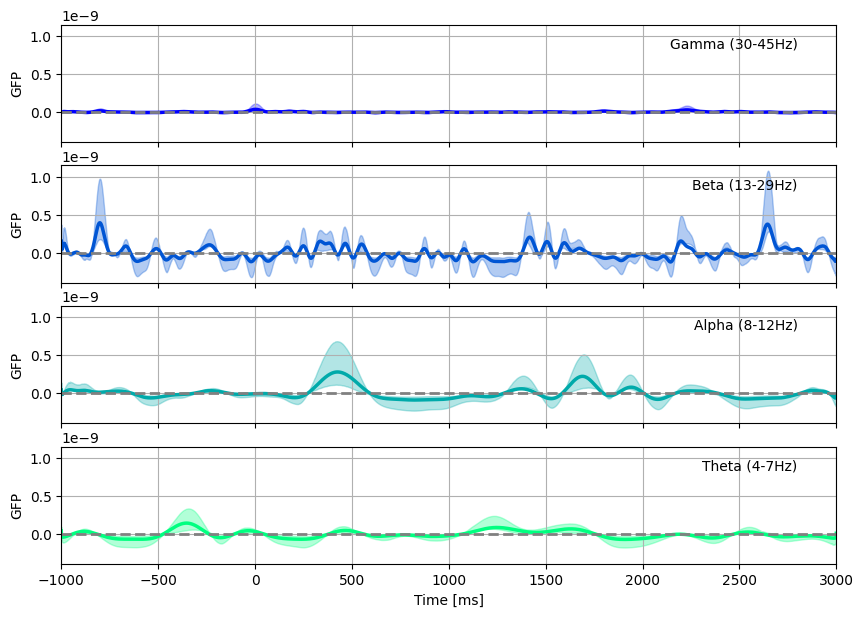

In [ ]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x**2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
    frequency_map, colors, axes.ravel()[::-1]
):
    times = average.times * 1e3
    gfp = np.sum(average.data**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.data, random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        "%s (%d-%dHz)" % (freq_name, fmin, fmax),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel("Time [ms]")

Теперь проверим через созданние событий

In [ ]:
events = mne.make_fixed_length_events(filt_rsvp, start=15, stop=60, duration=0.5)
epochs = mne.Epochs(filt_rsvp, events, event_id=1, tmin=-0.2, tmax=0.5, preload=True)

Not setting metadata
90 matching events found
Setting baseline interval to [-0.2001953125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 1435 original time points ...
0 bad epochs dropped


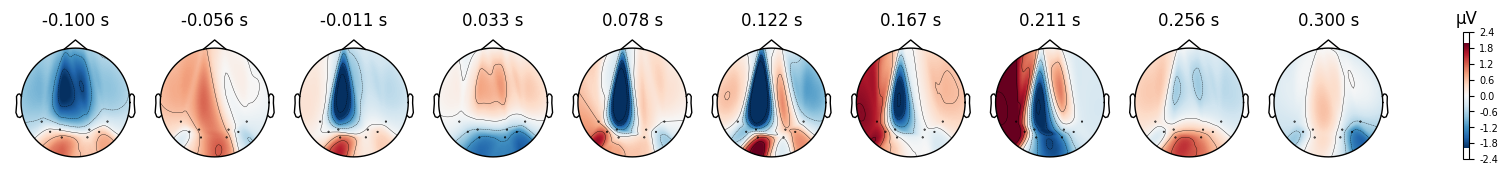

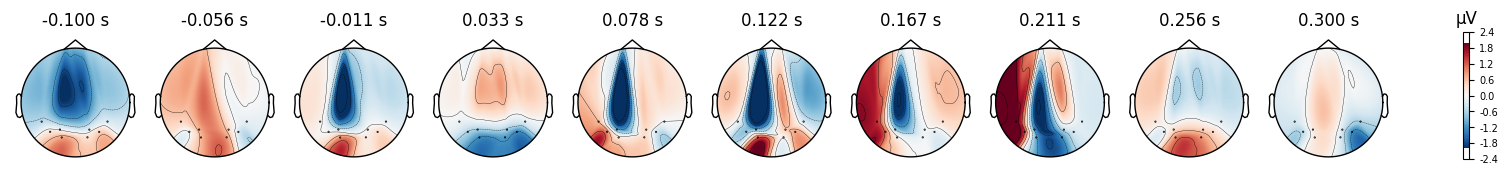

In [ ]:
evoked = epochs.average()
evoked.plot_topomap(times=np.linspace(-0.1, 0.3, 10))

No projector specified for this dataset. Please consider the method self.add_proj.


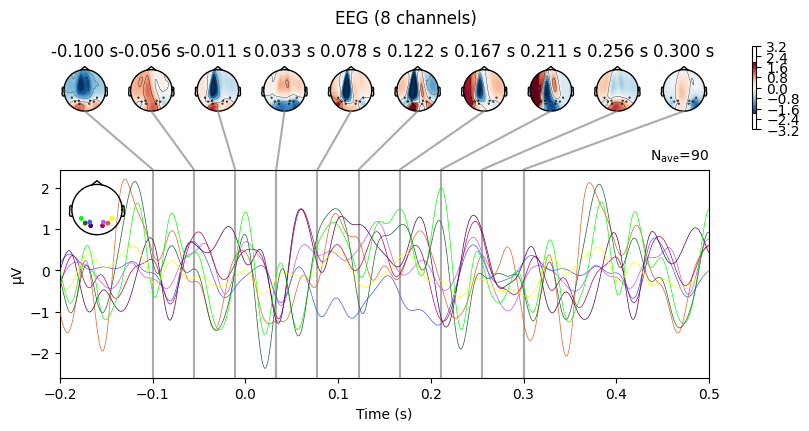

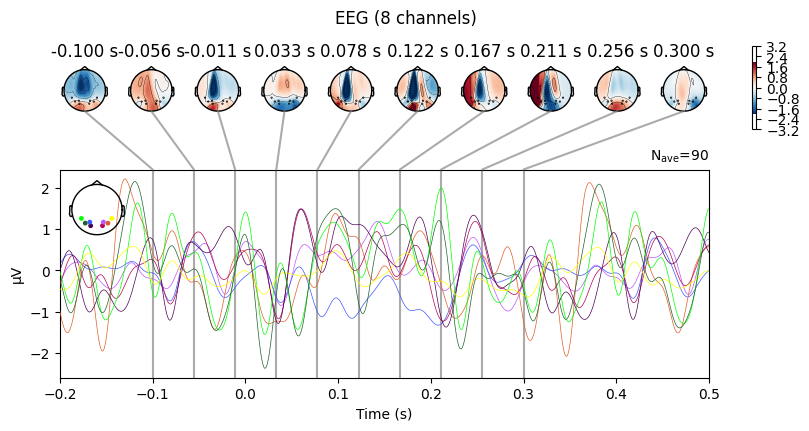

In [ ]:
evoked.plot_joint(times=np.linspace(-0.1, 0.3, 10))

In [ ]:
# let's explore some frequency bands
baseline = None

iter_freqs = [("Theta", 4, 7), ("Alpha", 8, 12), ("Beta", 13, 29), ("Gamma", 30, 45)]

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = filt_rsvp.copy()
    #raw.pick(picks=["grad", "eog"])  # we just look at gradiometers
    raw.load_data()

    # bandpass filter
    raw.filter(
        fmin,
        fmax,
        n_jobs=None,  # use more jobs to speed up.
        l_trans_bandwidth=1,  # make sure filter params are the same
        h_trans_bandwidth=1,
    )  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(
        raw,
        events,
        event_id=1,
        tmin=-1,
        tmax=3.0,
        baseline=baseline,
        preload=True,
    )
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs
del raw

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 6759 samples (3.300 s)

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 8193 original time points ...
0 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wind

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

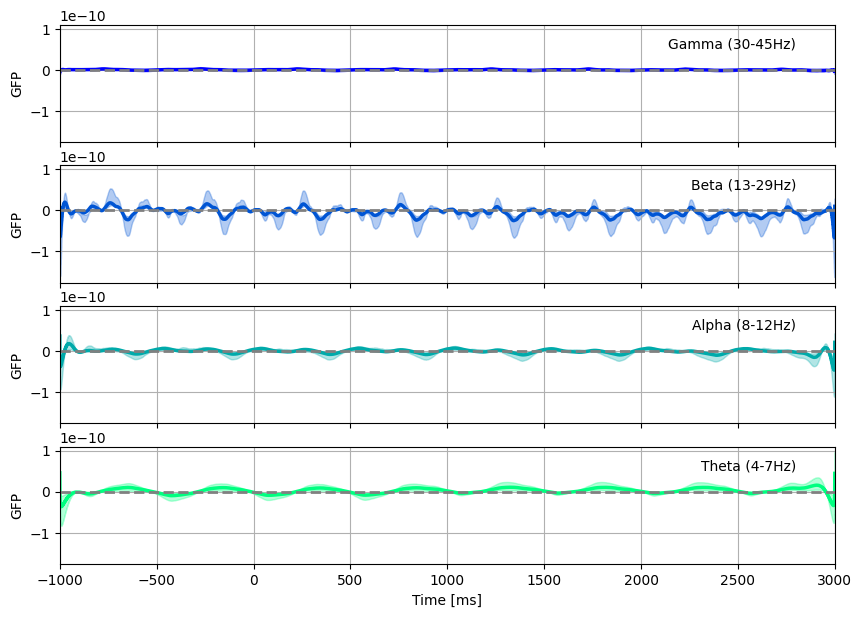

In [ ]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x**2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
    frequency_map, colors, axes.ravel()[::-1]
):
    times = average.times * 1e3
    gfp = np.sum(average.data**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.data, random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        "%s (%d-%dHz)" % (freq_name, fmin, fmax),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel("Time [ms]")